Deep Learning using Rectified Linear Units
===

## Overview

In this notebook, we explore the performance of a neural net with varying activation functions on an image classification task.

We load our dependencies.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

__version__ = '1.0.0'
__author__ = 'Abien Fred Agarap'

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

We set up the GPU memory growth.

In [2]:
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

We set the random seeds for reproducibility.

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

We set the batch size, the number of epochs, and the number of units per layer.

In [4]:
batch_size = 1024
epochs = 300
neurons = [512, 512]

## Data Preparation

We load the Fashion-MNIST dataset.

In [5]:
(train_features, train_labels), (test_features, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

We scale the images.

In [6]:
train_features = train_features.astype('float32').reshape(-1, 784) / 255.
test_features = test_features.astype('float32').reshape(-1, 784) / 255.

We one-hot encode labels.

In [7]:
train_labels = tf.one_hot(train_labels, 10)
test_labels = tf.one_hot(test_labels, 10)

We create a `tf.data.Dataset` object for the training dataset.

In [8]:
dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels))
dataset = dataset.prefetch(4096).shuffle(2048).batch(batch_size, True)

## Model

We write a `NeuralNet` class that consists of two hidden layers.

In [9]:
class NeuralNet(tf.keras.Model):
    def __init__(self, **kwargs):
        super(NeuralNet, self).__init__()
        self.hidden_layer_1 = tf.keras.layers.Dense(
            units=kwargs['units'][0],
            activation=kwargs['activation'],
            kernel_initializer=kwargs['initializer']
        )
        self.hidden_layer_2 = tf.keras.layers.Dense(
            units=kwargs['units'][1],
            activation=kwargs['activation'],
            kernel_initializer=kwargs['initializer']
        )
        self.output_layer = tf.keras.layers.Dense(units=kwargs['num_classes'])
        self.optimizer = tf.optimizers.SGD(learning_rate=3e-4, momentum=9e-1)
    
    @tf.function
    def call(self, features):
        activation = self.hidden_layer_1(features)
        activation = self.hidden_layer_2(activation)
        output = self.output_layer(activation)
        return output

We define our loss function.

In [10]:
def loss_fn(logits, labels):
    softmax_loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels)
    return tf.reduce_mean(softmax_loss)

We define a function for a training step.

In [11]:
def train_step(model, loss, features, labels):
    with tf.GradientTape() as tape:
        logits = model(features)
        train_loss = loss(logits=logits, labels=labels)
    gradients = tape.gradient(train_loss, model.trainable_variables)
    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return train_loss

We define a training function.

In [12]:
def train(model, loss_fn, dataset, epochs):
    epoch_accuracy = []
    epoch_loss = []
    for epoch in range(epochs):
        train_accuracy = []
        train_loss = 0
        for batch_features, batch_labels in dataset:
            batch_features += tf.random.normal(stddev=(1. / (1. + epoch)**0.55), shape=batch_features.shape)
            loss = train_step(model, loss_fn, batch_features, batch_labels)
            
            accuracy = tf.metrics.Accuracy()
            predictions = tf.nn.softmax(model(batch_features))
            accuracy(tf.argmax(predictions, 1), tf.argmax(batch_labels, 1))
            
            train_loss += loss
            train_accuracy.append(accuracy.result())
        
        epoch_loss.append(tf.reduce_mean(train_loss))
        epoch_accuracy.append(tf.reduce_mean(train_accuracy))
        
        if (epoch != 0) and ((epoch + 1) % 50 == 0):
            print('epoch {}/{} : mean loss = {}, mean accuracy = {}'.format(epoch + 1,
                                                                            epochs,
                                                                            tf.reduce_mean(train_loss),
                                                                            tf.reduce_mean(train_accuracy)))
    return epoch_accuracy, epoch_loss

### Logistic-based Model

We define a 2-layer NN with Logistic activation function.

In [13]:
model = NeuralNet(
    units=neurons,
    activation=tf.nn.sigmoid,
    initializer='glorot_uniform',
    num_classes=10
)

We train our model for 300 epochs.

In [14]:
logistic_performance = train(model, loss_fn, dataset, epochs=epochs)

epoch 50/300 : mean loss = 112.96251678466797, mean accuracy = 0.5909886956214905
epoch 100/300 : mean loss = 81.29564666748047, mean accuracy = 0.638554036617279
epoch 150/300 : mean loss = 64.67366027832031, mean accuracy = 0.6770777106285095
epoch 200/300 : mean loss = 55.834861755371094, mean accuracy = 0.7050276398658752
epoch 250/300 : mean loss = 50.10903549194336, mean accuracy = 0.7218648791313171
epoch 300/300 : mean loss = 46.06403350830078, mean accuracy = 0.733735203742981


We produce predictions for the test data.

In [15]:
predictions = tf.nn.softmax(model(test_features))

We compute the test accuracy.

In [16]:
accuracy = tf.metrics.Accuracy()
test_accuracy = accuracy(tf.argmax(predictions, 1), tf.argmax(test_labels, 1))

Check for the test accuracy.

In [17]:
print('Test accuracy : {}'.format(test_accuracy.numpy()))

Test accuracy : 0.7261000275611877


### TanH-based Model

We define a 2-layer NN with Hyperbolic Tangent activation function.

In [18]:
model = NeuralNet(
    units=neurons,
    activation=tf.nn.tanh,
    initializer='glorot_uniform',
    num_classes=10
)

We train our model for 300 epochs.

In [19]:
tanh_performance = train(model, loss_fn, dataset, epochs=epochs)

epoch 50/300 : mean loss = 32.850181579589844, mean accuracy = 0.8085263967514038
epoch 100/300 : mean loss = 28.206607818603516, mean accuracy = 0.8310546875
epoch 150/300 : mean loss = 26.22389793395996, mean accuracy = 0.8414937853813171
epoch 200/300 : mean loss = 25.05820655822754, mean accuracy = 0.8491379022598267
epoch 250/300 : mean loss = 24.178380966186523, mean accuracy = 0.853397786617279
epoch 300/300 : mean loss = 23.47045135498047, mean accuracy = 0.8579269647598267


We produce predictions for the test data.

In [20]:
predictions = tf.nn.softmax(model(test_features))

We compute the test accuracy.

In [21]:
accuracy = tf.metrics.Accuracy()
test_accuracy = accuracy(tf.argmax(predictions, 1), tf.argmax(test_labels, 1))

Check for the test accuracy.

In [22]:
print('Test accuracy : {}'.format(test_accuracy.numpy()))

Test accuracy : 0.843500018119812


### ReLU-based Model

We define a 2-layer NN with ReLU activation function.

In [23]:
model = NeuralNet(
    units=neurons,
    activation=tf.nn.relu,
    initializer='he_normal',
    num_classes=10
)

We train our model for 300 epochs.

In [24]:
relu_performance = train(model, loss_fn, dataset, epochs=epochs)

epoch 50/300 : mean loss = 32.64879608154297, mean accuracy = 0.81005859375
epoch 100/300 : mean loss = 27.672529220581055, mean accuracy = 0.8370824456214905
epoch 150/300 : mean loss = 25.412630081176758, mean accuracy = 0.8491715788841248
epoch 200/300 : mean loss = 23.92156982421875, mean accuracy = 0.8571356534957886
epoch 250/300 : mean loss = 22.777538299560547, mean accuracy = 0.8654195666313171
epoch 300/300 : mean loss = 21.968692779541016, mean accuracy = 0.868534505367279


We produce predictions for the test data.

In [25]:
predictions = tf.nn.softmax(model(test_features))

We compute the test accuracy.

In [26]:
accuracy = tf.metrics.Accuracy()
test_accuracy = accuracy(tf.argmax(predictions, 1), tf.argmax(test_labels, 1))

Check for the test accuracy.

In [27]:
print('Test accuracy : {}'.format(test_accuracy.numpy()))

Test accuracy : 0.8521000146865845


### Leaky ReLU-based Model

We define a 2-layer NN with Leaky ReLU activation function.

In [28]:
model = NeuralNet(
    units=neurons,
    activation=tf.nn.leaky_relu,
    initializer='he_normal',
    num_classes=10
)

We train our model for 300 epochs.

In [29]:
lrelu_performance = train(model, loss_fn, dataset, epochs=epochs)

epoch 50/300 : mean loss = 32.48524856567383, mean accuracy = 0.8092504143714905
epoch 100/300 : mean loss = 27.823711395263672, mean accuracy = 0.8356680870056152
epoch 150/300 : mean loss = 25.704376220703125, mean accuracy = 0.8470669388771057
epoch 200/300 : mean loss = 24.35843849182129, mean accuracy = 0.8554013967514038
epoch 250/300 : mean loss = 23.405973434448242, mean accuracy = 0.8613786101341248
epoch 300/300 : mean loss = 22.627296447753906, mean accuracy = 0.8656889796257019


We produce predictions for the test data.

In [30]:
predictions = tf.nn.softmax(model(test_features))

We compute the test accuracy.

In [31]:
accuracy = tf.metrics.Accuracy()
test_accuracy = accuracy(tf.argmax(predictions, 1), tf.argmax(test_labels, 1))

Check for the test accuracy.

In [32]:
print('Test accuracy : {}'.format(test_accuracy.numpy()))

Test accuracy : 0.8489000201225281


### Softplus-based Model

We define a 2-layer NN with Softplus activation function.

In [33]:
model = NeuralNet(
    units=neurons,
    activation=tf.nn.softplus,
    initializer='he_normal',
    num_classes=10
)

We train our model for 300 epochs.

In [34]:
softplus_performance = train(model, loss_fn, dataset, epochs=epochs)

epoch 50/300 : mean loss = 36.354644775390625, mean accuracy = 0.7826474905014038
epoch 100/300 : mean loss = 31.238855361938477, mean accuracy = 0.8138974905014038
epoch 150/300 : mean loss = 28.864168167114258, mean accuracy = 0.8275862336158752
epoch 200/300 : mean loss = 27.452871322631836, mean accuracy = 0.8369477391242981
epoch 250/300 : mean loss = 26.492555618286133, mean accuracy = 0.8424703478813171
epoch 300/300 : mean loss = 25.765352249145508, mean accuracy = 0.8478414416313171


We produce predictions for the test data.

In [35]:
predictions = tf.nn.softmax(model(test_features))

We compute the test accuracy.

In [36]:
accuracy = tf.metrics.Accuracy()
test_accuracy = accuracy(tf.argmax(predictions, 1), tf.argmax(test_labels, 1))

Check for the test accuracy.

In [37]:
print('Test accuracy : {}'.format(test_accuracy.numpy()))

Test accuracy : 0.8325999975204468


### ELU-based Model

We define a 2-layer NN with ELU activation function.

In [38]:
model = NeuralNet(
    units=neurons,
    activation=tf.nn.elu,
    initializer='he_normal',
    num_classes=10
)

We train our model for 300 epochs.

In [39]:
elu_performance = train(model, loss_fn, dataset, epochs=epochs)

epoch 50/300 : mean loss = 30.876705169677734, mean accuracy = 0.8188981413841248
epoch 100/300 : mean loss = 27.03605079650879, mean accuracy = 0.8384462594985962
epoch 150/300 : mean loss = 25.26348304748535, mean accuracy = 0.8483633995056152
epoch 200/300 : mean loss = 24.11379051208496, mean accuracy = 0.8556708097457886
epoch 250/300 : mean loss = 23.325796127319336, mean accuracy = 0.859745442867279
epoch 300/300 : mean loss = 22.671171188354492, mean accuracy = 0.8628097772598267


We produce predictions for the test data.

In [40]:
predictions = tf.nn.softmax(model(test_features))

We compute the test accuracy.

In [41]:
accuracy = tf.metrics.Accuracy()
test_accuracy = accuracy(tf.argmax(predictions, 1), tf.argmax(test_labels, 1))

Check for the test accuracy.

In [42]:
print('Test accuracy : {}'.format(test_accuracy.numpy()))

Test accuracy : 0.8479999899864197


## Training Performance

We lay down the training performance of each model.

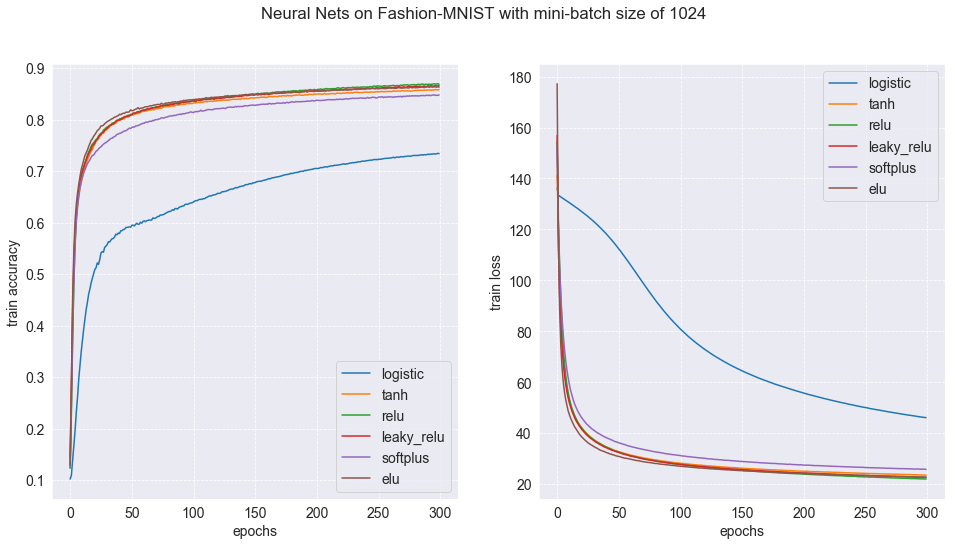

In [43]:
sns.set_style('dark', {'grid.linestyle': '--'})
plt.figure(figsize=(16, 8))
plt.rcParams.update({'font.size': 14})

plt.subplot(121)
plt.plot(range(len(logistic_performance[0])), logistic_performance[0], label='logistic')
plt.plot(range(len(tanh_performance[0])), tanh_performance[0], label='tanh')
plt.plot(range(len(relu_performance[0])), relu_performance[0], label='relu')
plt.plot(range(len(lrelu_performance[0])), lrelu_performance[0], label='leaky_relu')
plt.plot(range(len(softplus_performance[0])), softplus_performance[0], label='softplus')
plt.plot(range(len(elu_performance[0])), elu_performance[0], label='elu')
plt.xlabel('epochs')
plt.ylabel('train accuracy')
plt.legend(loc='lower right')
plt.grid()

plt.subplot(122)
plt.plot(range(len(logistic_performance[1])), logistic_performance[1], label='logistic')
plt.plot(range(len(tanh_performance[1])), tanh_performance[1], label='tanh')
plt.plot(range(len(relu_performance[1])), relu_performance[1], label='relu')
plt.plot(range(len(lrelu_performance[1])), lrelu_performance[1], label='leaky_relu')
plt.plot(range(len(softplus_performance[1])), softplus_performance[1], label='softplus')
plt.plot(range(len(elu_performance[1])), elu_performance[1], label='elu')
plt.xlabel('epochs')
plt.ylabel('train loss')
plt.legend(loc='upper right')
plt.grid()

plt.suptitle('Neural Nets on Fashion-MNIST with mini-batch size of 1024')
plt.savefig('fmnist_experiments_1024.png', dpi=300)
plt.show()